# Project 1

In [1]:
## Importing modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
#from scipy.special import erfinv
from scipy.integrate import quad
from iminuit import Minuit

Creating a class for the exponential decay with a constant background and a sinusoidal oscillation as given in the question

In [2]:
class ExpDecay:
    """
    Class for exponential decay with a constant background.
    
    Parameters
    ----------
    V: float
        Amplitude of the oscillation
    dm: float
        Frequency of the oscillation
    lifetime: float
        Lifetime of the decay
    TMIN: float
        Minimum time for the decay or start time of decay obersevation
    TMAX: float
        Maximum time for the decay or end time of decay obersevation
    
    Methods
    -------
    decay_pdf(t)
        Probability density function for the decay
    integral()
        Integral of the decay_pdf
    evaluate(t)
        Evaluate the decay_pdf at time t
    """
    
    def __init__(self, V, dm, lifetime, TMIN=0, TMAX=10):
        self.V = V
        self.dm = dm
        self.lifetime = lifetime
        self.TMIN = TMIN
        self.TMAX = TMAX


    def decay_pdf(self, t):
        return (1+self.V*np.sin(self.dm*t)) * (np.exp(-(t/self.lifetime)))


    def integral(self):
        return quad(self.decay_pdf, self.TMIN, self.TMAX)[0]

    
    def evaluate(self, t):
        return self.decay_pdf(t) / self.integral()

In [3]:
## Defining all constants for PDF and data generation ##

LIFETIME = 1.5 # arbitrary units
DM = 20. # arbitrary units
V = 0.1

EVENTS = 10000
MCRUNS = 100
TMIN = 0
TMAX = 10

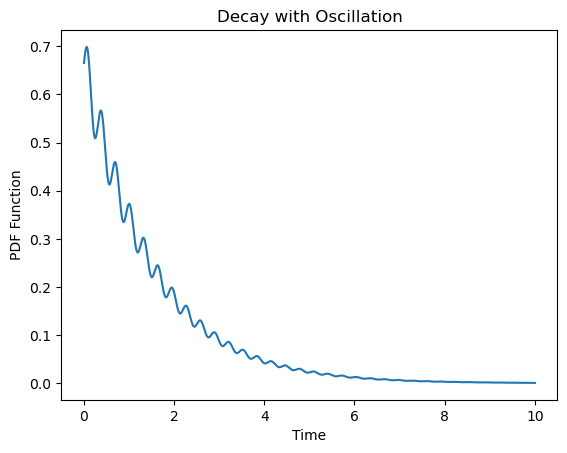

In [4]:
## SANITY CHECK CODE BLOCK ##
## ----------------------- ##
# Checking the function is coded correctly and plotting it to understand the distribution visually

# Generate time values (Here, uniformly distributed but is random for the rest of the project)
t_values_check = np.linspace(0, 10, 10000)

# Calculate function values
pdf = ExpDecay(V, DM, LIFETIME, TMIN, TMAX)
y_values_check = pdf.evaluate(t_values_check)

# Plot the function
plt.plot(t_values_check, y_values_check)
plt.xlabel('Time')
plt.ylabel('PDF Function')
plt.title('Decay with Oscillation')
plt.show()

### Part 1: Estimating statistical precision [5 marks]

Use the method of multiple pseudo-experiments (toy Monte Carlo event generation) to determine
the expected statistical precision with which one could measure each of the parameters with 10000
events. You should:
<p>
• Use a time range of [0,10] to generate your events<br>
• Generate and make a histogram of a single dataset first, in order to check your PDF is working. You may wish to increase V temporarily to make the oscillations term more visible.<br>
• Use a maximum likelihood fit to determine the precision expected for each of the parameters τ, ∆m and V (hint: you need enough toy datasets to perform the required statistical analysis, typically at least 100).<br>
• Determine the bias (if any) for each parameter. To do this you need to know how to estimate the bias as well as the precision of the bias, in order to know if it is significant. <br>
<p>
<i>Hint: Because this involves a lot of generation of events (100 toys @ 10000 events) it is better to use a much
smaller number to develop your code. Then it will run much faster. It is suggested you start with 10 toys
@ 1000 events, to make sure code runs, then 50 toys @3000 events for main development, and then at least
100 toys @ 10000 events when the code is mostly all working and to produce your final results.</i>

Creating a GenData class to generate data with the pdf. Using a class to keep all simulation data generation in one place. The methods within this class are being called at the relevent positions

In [5]:
class GenData:
    """
    Generates data with a given PDF
    
    Parameters
    ----------
    pdf: PDF class
        Given PDF to generate data from
    EVENTS: int
        Number of events to generate
    interval: tuple
        Tuple of (lower, upper) limits to generate data between. Default is (0, 10)
    
    Methods
    -------
    exp_data()
        Generates a singal dataset with the given number of events with the given PDF
    exp_data_MC(MCRUNS)
        Generates MCRUNS number of data sets from the given PDF
    """

    def __init__(self, EVENTS, V, DM, LIFETIME, TMIN, TMAX, interval=(0, 10)):
        self.pdf = ExpDecay(V, DM, LIFETIME, TMIN, TMAX)
        self.EVENTS = EVENTS
        self.lolimit = interval[0]
        self.hilimit = interval[1]


    def exp_data(self):
        """
        Generates data from the given PDF that is normalised with the limits of 
        interval (low and high of time). Using the box method where the random 
        generator is bounded by a box of height 1 in the y-direction and the limits 
        of the PDF in the x-direction.

        The function will generate a random number of points. It will then only 
        keep the points that are below the PDF curve and reject the points that 
        are above the curve. This ensures that the points are distributed according 
        to the PDF. A new set of random points will be generated for the rejected
        points repeatedly rejecting any below the curve until all the points are 
        below the curve.

        Returns
        -------
        rand_t : array
            Array of random time values that follow the PDF
        """
        rand_t = np.random.uniform(self.lolimit, self.hilimit, size=self.EVENTS)
        rand_y = np.random.uniform(size=self.EVENTS)

        y_accept = self.pdf.evaluate(rand_t)
        mask = rand_y > y_accept  # Rejecting any points that are above the curve

        while any(mask):  # While there are still points to be rejected
            rand_t[mask] = np.random.uniform(self.lolimit, self.hilimit, size=np.count_nonzero(mask))
            rand_y[mask] = np.random.uniform(size=np.count_nonzero(mask))

            y_accept[mask] = self.pdf.evaluate(rand_t[mask])
            mask = rand_y > y_accept

        return rand_t
    

    def exp_data_MC(self, MCRUNS):
        t_array = np.empty((MCRUNS, self.EVENTS))
        for i in range(MCRUNS):
            t_array[i] = self.exp_data()

        return t_array
    


class GenDataBkg:
    def __init__(self, EVENTS, V, DM, LIFETIME, BKGLIFETIME, TMIN, TMAX, F, interval=(0, 10)):
        self.signal = ExpDecay(V, DM, LIFETIME, TMIN, TMAX)
        self.bkg = ExpDecay(V, DM, BKGLIFETIME, TMIN, TMAX)
        self.EVENTS = EVENTS
        self.lolimit = interval[0]
        self.hilimit = interval[1]
        self.F = F


    def exp_with_bkg(self):
        rand_t = np.random.uniform(self.lolimit, self.hilimit, size=self.EVENTS)
        rand_y = np.random.uniform(size=self.EVENTS)

        y_accept = (1-self.F)*self.signal.decay_pdf(rand_t) + self.F*self.bkg.decay_pdf(rand_t)
        mask = rand_y > y_accept  # Reject points that are above the curve

        while any(mask):  # While there are still points to rejected
            rand_t[mask] = np.random.uniform(self.lolimit, self.hilimit, size=np.count_nonzero(mask))
            rand_y[mask] = np.random.uniform(size=np.count_nonzero(mask))

            y_accept[mask] = (1-self.F)*self.signal.decay_pdf(rand_t[mask]) + self.F*self.bkg.decay_pdf(rand_t[mask])
            mask = rand_y > y_accept

        return rand_t

Generating a single experiment/toy with 10000 events to double check that code works and does what is required. Also checking if outputs.

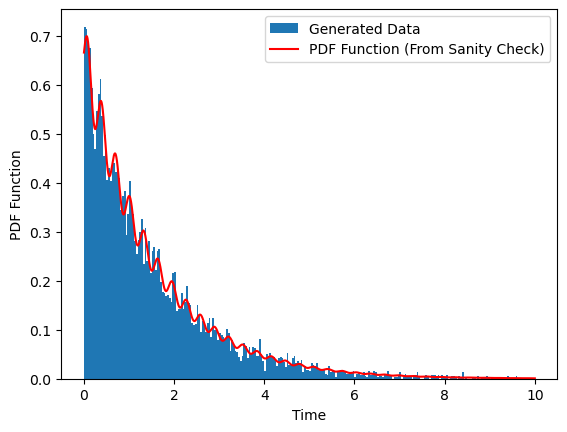

In [6]:
t_values = GenData(EVENTS, V, DM, LIFETIME, TMIN, TMAX, interval=(0, 10)).exp_data()

# Using 'density=True' to normalizes the histogram 
# Bins are set as 250 to get a smooth curve visually that somewhat matches the PDF function
plt.hist(t_values, bins=250, density=True, label='Generated Data')
plt.plot(t_values_check, y_values_check, color='red', label='PDF Function (From Sanity Check)')
plt.xlabel('Time')
plt.ylabel('PDF Function')
plt.legend()
plt.show()

Generating 100 experiments for Monte-Carlo simulation

In [7]:
t_values = GenData(EVENTS, V, DM, LIFETIME, TMIN, TMAX, interval=(0, 10)).exp_data_MC(MCRUNS)

# Printing the shape of the array to check right dimensions have been created
print(t_values.shape) 

(100, 10000)


In [8]:
def Nll(V, DM, LIFETIME):
    pdf = ExpDecay(V, DM, LIFETIME, TMIN=TMIN, TMAX=TMAX)
    return -np.sum(np.log(pdf.decay_pdf(t_set)/pdf.integral()))


startvals = {
        'V': V,
        'DM': DM,
        'LIFETIME': LIFETIME,
    }

Min_vals = []
for t_set in t_values:
    Min = Minuit(Nll, **startvals)
    Min.errordef = 0.5
    Min.hesse()
    Min.migrad()  # find minimum

    Min_vals.append(Min.values)

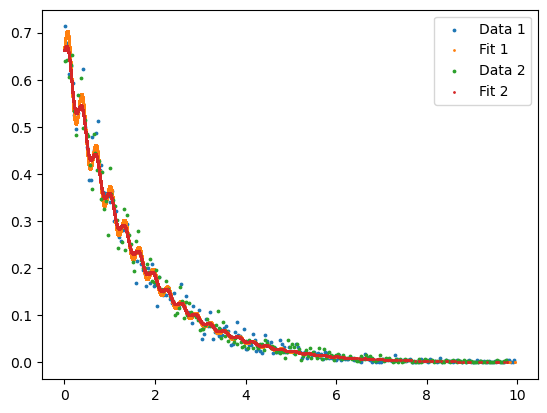

In [9]:
## SANITY CHECK CODE BLOCK ##
## ----------------------- ##
# Checking if the minimisation fits the data correctly (with a plot) for the first 2 data sets

def get_hist_info(data, NBINS, density=False):
    # Derive the appropriate numbers in the data
    # Here shifting x values to the center of the bins and
    # getting the height of the bin for y values
    
    n, bins = np.histogram(data, bins=NBINS, density=density)
    bins = [(bins[i] + bins[i+1])/2. for i in range(len(bins)-1)]
    bins = np.array(bins)
    n = np.array(n)
    
    return bins, n


for i, (Min_val, t_set) in enumerate(zip(Min_vals[:2], t_values[:2])):
    x, y = get_hist_info(t_set, 250, density=True)
    plt.scatter(x, y, s=3, label='Data {0}'.format(i+1))

    pdf = ExpDecay(Min_val['V'], Min_val['DM'], Min_val['LIFETIME'], TMIN=TMIN, TMAX=TMAX)
    plt.scatter(t_set, pdf.evaluate(t_set), s=1, label='Fit {0}'.format(i+1))

plt.legend()
plt.show()

### Part 2: Estimating possible bias due to an unaccounted for background [5 marks]

In this part you will use the same signal PDF as in PART1. We hypothesise that the data has an additional background component within it that we do not know about. In this example the background will be another exponential with a much longer lifetime: it is 8 units (compared to 1.5 for the signal). For this exercise you will:
<p>
• Generate 5 data sets (each set being 10000 events), each with a different exponential background fraction (with a lifetime of 8) added to the signal. The fractions will be [0.0, 0.1, 0.2, 0.3, 0.4]. Use a time range of [0,10] to generate your events; <br>
• Fit to each of these data sets as if you do not know about the background. In other words you will use only the signal PDF used in PART1 for the fit; <br>
• Create plots showing how the fitted value of each parameter τ, ∆m and V varies as a function of the background fraction; <br>
• Comment on any observed bias/trend and whether it is significant. To do this you need to compare any change seen in a parameter to its error. <br>
<p>
Remember, you are only asked to generate a single toy data set for each background fraction in
order to limit the time needed to run your code. In reality one would generate more toys at each
point or run with more events.
<p>
<i>Hint To generate the data in this part you need a composite PDF containing both the signal PDF and
the background PDF. The easiest way to do this is create a new PDF as the sum of
(1-F)*SignalPDF + F*BackgoundPDF <br>
where F is the fraction of background. If each of your PDFs is correctly normalised, then so wil the compound PDF be automatically.</i>

In [10]:
## Defining new constants for PDF and data generation ##

BKGLIFETIME = 8.
F = [0.0, 0.1, 0.2, 0.3, 0.4]
TMIN = 0.
TMAX = 10.
G = 1.

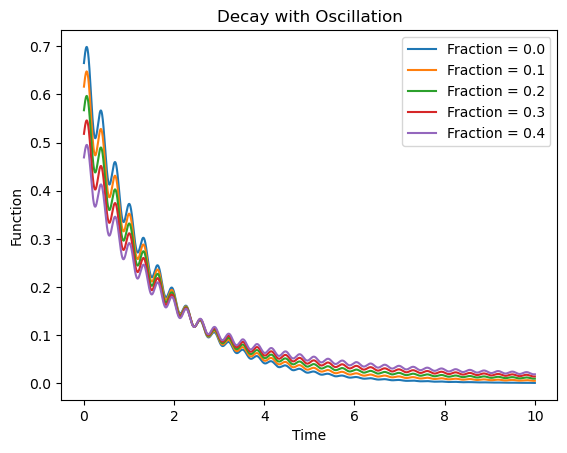

In [11]:
## SANITY CHECK CODE BLOCK ##
## ----------------------- ##

# Generate time values
t_values = np.linspace(0, 10, 10000)

# Calculate function values
pdf_signal = ExpDecay(V, DM, LIFETIME, TMIN, TMAX)
pdf_bkg = ExpDecay(V, DM, BKGLIFETIME, TMIN, TMAX)

for frac in F:
    y_values = (1-frac)*pdf_signal.evaluate(t_values) + frac*pdf_bkg.evaluate(t_values)
    plt.plot(t_values, y_values, label='Fraction = {}'.format(frac))

# Plot the function
plt.xlabel('Time')
plt.ylabel('Function')
plt.legend()
plt.title('Decay with Oscillation')
plt.show()

Generating datasets for eaach of the background fractions that are then run into the ```Minuit``` minimiser to get fitted parameters and their errors.

In [12]:
def exp_bkg_frac(EVENTS, V, DM, LIFETIME, BKGLIFETIME, TMIN, TMAX, F, interval=(0, 10)):
    """
    Generates data from the given PDF that is normalised with the limits of the
    interval (low limit and high limit of time). Here, the GenDataBkg.exp_with_bkg
    is repeatedly called to generate data for each fraction in F.

    Parameters
    ----------
    EVENTS: int
        Number of events to generate
    interval: tuple
        Tuple of (lower, upper) limits to generate data between. Default is (0, 10)
    
    Returns
    -------
    rand_t : array
        Array of random time values that follow the PDF
    """

    t_array = []
    for i, frac in enumerate(F):
        t_array.append(GenDataBkg(EVENTS, V, DM, LIFETIME, BKGLIFETIME, TMIN, TMAX, frac, interval=interval).exp_with_bkg())

    return np.array(t_array)

t_values = exp_bkg_frac(EVENTS, V, DM, LIFETIME, BKGLIFETIME,TMIN, TMAX, F, interval=(0, 10))

Minimising varied parameters (V, dm and Lifetime)

In [13]:
def min_func(V, DM, LIFETIME):
    pdf = ExpDecay(V, DM, LIFETIME, TMIN=TMIN, TMAX=TMAX)
    return -np.sum(np.log(pdf.evaluate(t_set)))


Min_vals = []
Min_vals_errors = []
for t_set in t_values:
    startvals = {
            'V': V,
            'DM': DM,
            'LIFETIME': LIFETIME,
            }

    Min = Minuit(min_func, **startvals)
    Min.errordef = 0.5
    Min.hesse()
    Min.migrad()  # find minimum

    Min_vals.append(Min.values)
    Min_vals_errors.append(Min.errors)


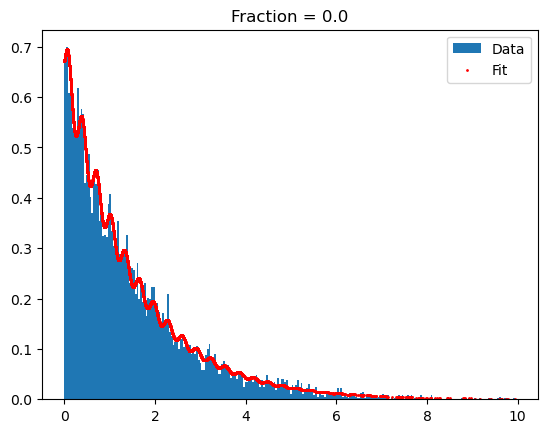

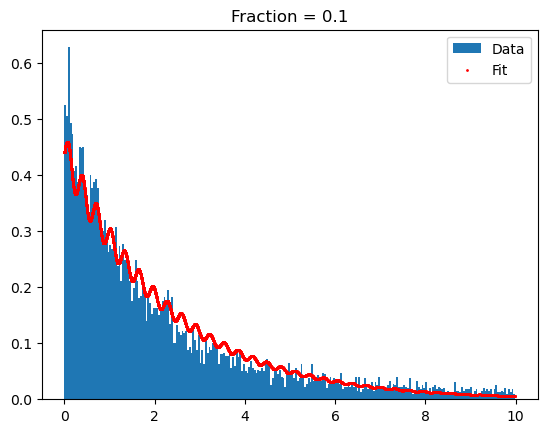

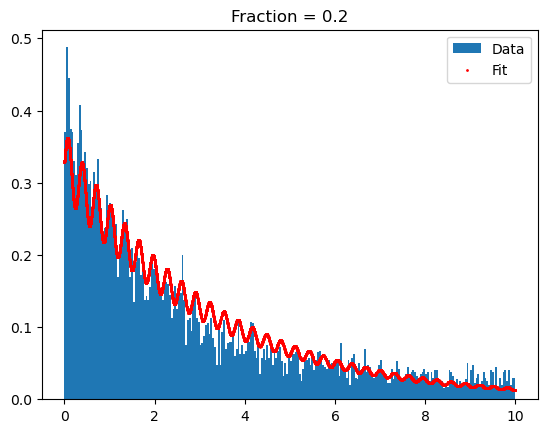

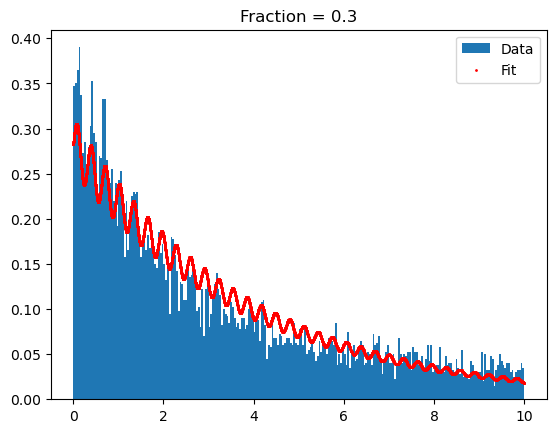

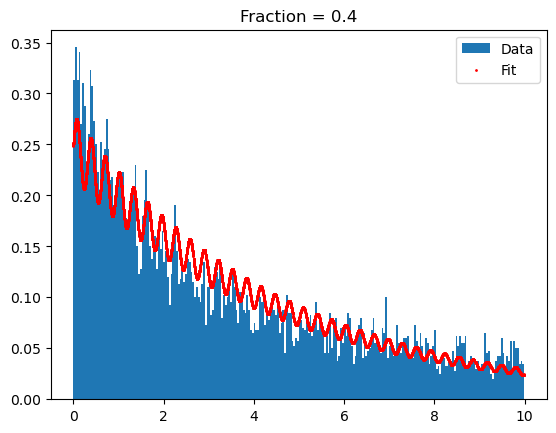

In [14]:
## SANITY CHECK CODE BLOCK ##
## ----------------------- ###
# Checking minimised fits

for i in range(len(F)):
    plt.title('Fraction = {}'.format(F[i]))
    model = ExpDecay(Min_vals[i]['V'], Min_vals[i]['DM'], Min_vals[i]['LIFETIME'], TMIN=TMIN, TMAX=TMAX)
    plt.hist(t_values[i], bins=250, density=True, label='Data')
    plt.scatter(t_values[i], model.evaluate(t_values[i]), label='Fit', s=1, color='red')
    plt.legend()
    plt.show()

In [15]:
# Storing the values and errors for later analysis

v_values, dm_values, lifetime_values = zip(*np.array([(value['V'], value['DM'], value['LIFETIME']) for value in Min_vals]))
v_values, dm_values, lifetime_values = np.array(v_values), np.array(dm_values), np.array(lifetime_values)

v_errors, dm_errors, lifetime_errors = zip(*[(value['V'], value['DM'], value['LIFETIME']) for value in Min_vals_errors])
v_errors, dm_errors, lifetime_errors = np.array(v_errors), np.array(dm_errors), np.array(lifetime_errors)

Plotting the errors against the background fraction to understand trends

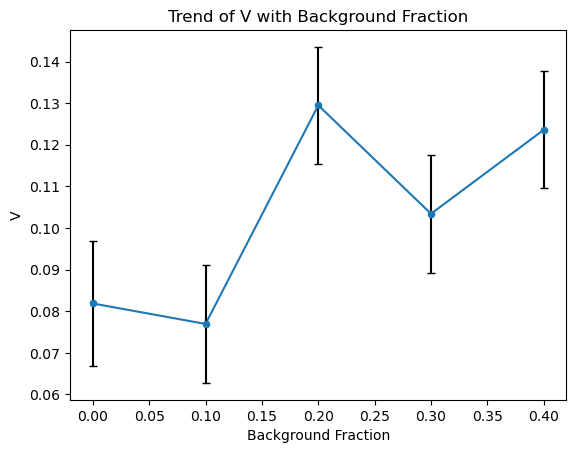

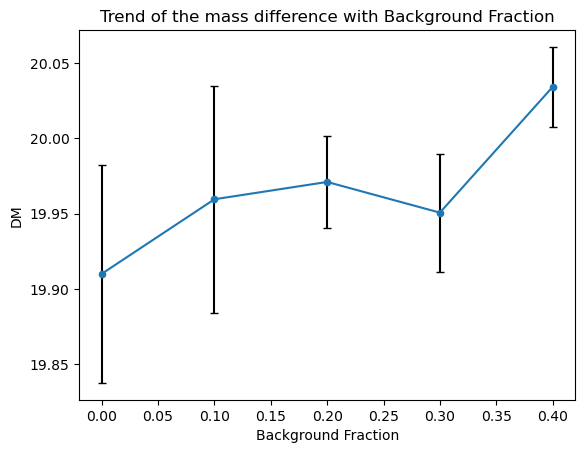

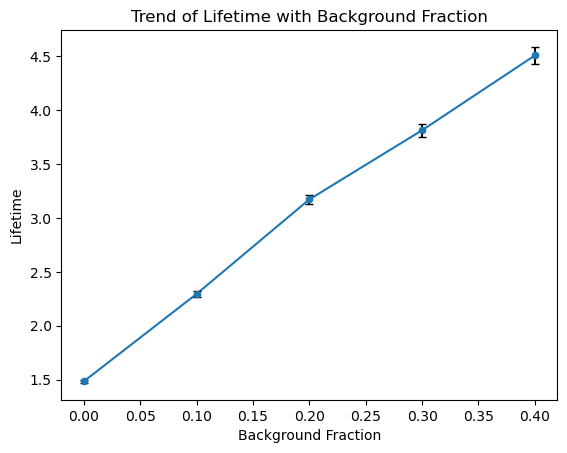

In [16]:
plt.plot(F, v_values, label='V')
plt.errorbar(F, v_values, yerr=v_errors, fmt='o', c='#1f77b4', ecolor='black', capsize=3, markersize='4.5')
plt.title('Trend of V with Background Fraction')
plt.ylabel('V')
plt.xlabel('Background Fraction')
plt.show()

plt.plot(F, dm_values, label='DM')
plt.errorbar(F, dm_values, yerr=dm_errors, fmt='o', color='#1f77b4', ecolor='black', capsize=3, markersize='4.5')
plt.title('Trend of the mass difference with Background Fraction')
plt.ylabel('DM')
plt.xlabel('Background Fraction')
plt.show()

plt.plot(F, lifetime_values, label='Lifetime')
plt.errorbar(F, lifetime_values, yerr=lifetime_errors, fmt='o', color='#1f77b4', ecolor='black', capsize=3, markersize='4.5')
plt.title('Trend of Lifetime with Background Fraction')
plt.ylabel('Lifetime')
plt.xlabel('Background Fraction')
plt.show()

In the above figures, the lifetime is seen have a high bias as the fraction of the background is increased. This means that ignoring the background or considering it negligible would provide for incorrct estimates and therefore the background should be taken into account. The bias in the mass difference is not very significant compared to the bias of the V parameter.